In [1]:

import warnings
from NFL_Injury_Cleaning_Functions import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
import keras_tuner as kt

pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
seed = 42


# Import the Messy Data

Import the playlist and injuries lists, then clean and merge the data using the functions defined in NFL_Injury_Cleaning_Functions. Because this is going to be a neural network model, this will need to be all numerical data. 

1. Create an additional column called "IsInjury" to create a binary predictor for whether something is an injury or not
2. Drop the other columns associated with the injuries - these will be revisited later
3. Prior to merging with the tracking data...
    a. Select the IsInjured == 0 Subset from the list
    b. Sample 
4. Load tracking data for the merge, and remove non-numerical columns, perform inner merge


In [2]:
playlist = pd.read_csv("NFL_Turf/PlayList.csv")
injuries = pd.read_csv("NFL_Turf/InjuryRecord.csv")

In [3]:
ml = ML_Data_Cleaner(playlist, injuries)
ml.head()

,PlayKey,RosterPosition,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,InjuryType,InjuryDuration,SevereInjury
0,26624-1-1,0,63,1,0,1,1,0,64,0.0,0.0,0.0,0.0
1,26624-1-2,0,63,2,0,1,1,0,64,0.0,0.0,0.0,0.0
2,26624-1-3,0,63,3,0,1,1,0,64,1.0,0.0,0.0,0.0
3,26624-1-4,0,63,4,0,1,1,0,64,1.0,0.0,0.0,0.0
4,26624-1-5,0,63,5,0,1,1,0,64,0.0,0.0,0.0,0.0


In [4]:
# The numpy where function reads as follows... set ml.IsInjured equal to 0
# where ml.InjuryType == 0, else set equal to 1. All injuryType 0 values are not injures,
# everything else is an injury

ml['IsInjured'] = np.where(ml['InjuryType'] == 0, 0, 1)


In [5]:
ml.IsInjured.value_counts()

0    260653
1        77
Name: IsInjured, dtype: int64

## Sampling the Non-Injury Data

We are using an undersampling method to perform the neural network analysis, though we will be maintaining an imbalanced dataset. We reduced the number of Non-Injured plays such that the Injured plays make up 1% of all plays in the dataset. To do this, we separated the Injury Plays from the Non-Injury plays so as not to reduce the number of positive results. This is done prior to merging with the tracking data, which will exponentially expand the data. 

In [6]:
ml_y = ml.loc[ml.IsInjured == 1]
ml_X = ml.loc[ml.IsInjured == 0]

In [7]:
samp = ml_X.sample(n=7700, random_state=seed)
samp.head()

,PlayKey,RosterPosition,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,InjuryType,InjuryDuration,SevereInjury,IsInjured
95156,41084-24-12,24,70,12,24,1,0,0,147,0.0,0.0,0.0,0.0,0
50146,38252-9-2,3,28,2,3,0,1,0,134,0.0,0.0,0.0,0.0,0
170716,44067-7-4,5,70,4,7,1,0,0,155,1.0,0.0,0.0,0.0,0
23486,36554-17-9,15,69,9,17,0,1,0,23,1.0,0.0,0.0,0.0,0
241962,46038-26-51,25,33,51,27,0,1,0,162,0.0,0.0,0.0,0.0,0


In [8]:
ml_y = ml_y.append(samp, ignore_index=True, sort=False)

## Merge the Tracking Data with the other data

- Load the tracking data
- Drop the columns from tracking that are not necessary
- perform an inner merge between the datasets

In [9]:
tracking = pd.read_csv('NFL_Turf/PlayerTrackData.csv')
tracking.drop(columns=['event', 'dis', 'time'], inplace=True)
tracking.head()

,PlayKey,x,y,dir,o,s
0,26624-1-1,87.46,28.93,288.24,262.33,0.13
1,26624-1-1,87.45,28.92,283.91,261.69,0.12
2,26624-1-1,87.44,28.92,280.40,261.17,0.12
3,26624-1-1,87.44,28.92,278.79,260.66,0.10
4,26624-1-1,87.44,28.92,275.44,260.27,0.09


In [10]:
ml_merged = pd.merge(tracking, ml_y, on='PlayKey', how='inner')
ml_merged.head()

,PlayKey,x,y,dir,o,s,RosterPosition,Temperature,PlayerGamePlay,Position,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,InjuryType,InjuryDuration,SevereInjury,IsInjured
0,26624-1-45,21.32,29.14,344.76,321.52,0.88,0,63,45,0,1,1,0,64,0.0,0.0,0.0,0.0,0
1,26624-1-45,21.31,29.21,343.64,328.05,0.91,0,63,45,0,1,1,0,64,0.0,0.0,0.0,0.0,0
2,26624-1-45,21.30,29.29,342.20,334.59,0.93,0,63,45,0,1,1,0,64,0.0,0.0,0.0,0.0,0
3,26624-1-45,21.28,29.38,341.12,340.70,0.93,0,63,45,0,1,1,0,64,0.0,0.0,0.0,0.0,0
4,26624-1-45,21.26,29.45,340.04,346.24,0.89,0,63,45,0,1,1,0,64,0.0,0.0,0.0,0.0,0


## Remove the large datasets from memory

ml_merged contains the tracking data from tracking.csv merged with the features extracted from the injuryreports.csv and playlist.csv, and maintains several columns that could be used for predictive analysis. 

In [11]:
del ml, tracking, playlist, injuries, ml_X, samp, ml_y

# Prepare the Training and Testing sets

Columns that need to be removed or separated:
- PlayKey is non-informative and object-type
- SevereInjury and InjuryDuration cannot be part of the same training set, as they are not independent 
- For one of the analyses, InjuryType will be the prediction, so we want to exclude the InjuryDuration and SevereInjury, as we're trying to determine the other factors leading to such injuries
- In predicting the severity and/or duration of injury, a few sub-analyses can be performed
    - Looking only at factors that lead to severe injury without respect to injury type
    - Looking at the factors including injury type that predict the duration of injury
    - Looking at the factors that predict BOTH injury type and Severity (or perhaps duration)

The following tests will be performed: 
1. Can the model predict whether an injury occurred in a 99:1 imbalance of data?
2. Can the model predict whether a severe injury is likely to occur?


---
# Random Forests
## Injury Prediction

In [12]:
X = ml_merged.drop(columns=['PlayKey', 'IsInjured', 'SevereInjury', 'InjuryDuration', 'InjuryType', 'Position'])
y = ml_merged.IsInjured

# Because the True case only represents 1% of the data, the training split is stratifying on y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

In [13]:
# Create the Classifier
barf = BalancedRandomForestClassifier(n_estimators=10, random_state=seed)

# Fit the model
barf.fit(X_train, y_train)

# Calculate predicted accuracy score
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9997917026159623

In [14]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    549957
          1       0.98      1.00      1.00      0.99      1.00      1.00      5549

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    555506



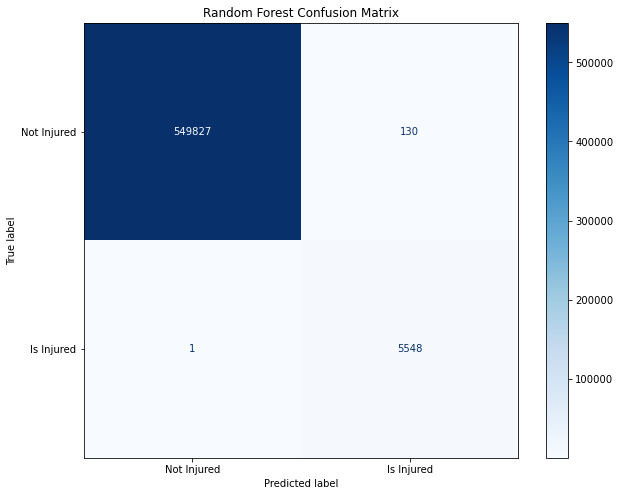

In [15]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(barf, X_test, y_test, display_labels=[
                      "Not Injured", "Is Injured"], cmap='Blues', values_format='d', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

Results: 
- The Random Forest Classifier with 10 estimators yielded a 99.98% accuracy
- There were 0 to 1 false negatives, which is better for this predictive model
- There were 130 False positives, compared to the nearly 550,000 true Negatives

To further assess which features influenced the model the most, we will perform a feature analysis

In [16]:
sorted(zip(barf.feature_importances_, X.columns), reverse=True)

[(0.19620276138059084, 'DaysPlayed'),
 (0.18091133248803332, 'Temperature'),
 (0.1705155031224724, 'PlayerGamePlay'),
 (0.11957690765142559, 'x'),
 (0.10289266553924122, 'RosterPosition'),
 (0.06239791610361366, 'y'),
 (0.04932860308673036, 'PlayCode'),
 (0.02521048225274087, 'SyntheticField'),
 (0.02255172905076227, 'o'),
 (0.02040492304080988, 'Outdoor'),
 (0.0188003225140538, 's'),
 (0.016436388680310658, 'Precipitation'),
 (0.014770465089215225, 'dir')]

### What does this mean? 
- DaysPlayed represents how many days into each season the player has played, 18.9% weight
- PlayerGamePlay is how far into the individual game the player has played, 18.9% weight
- Temperature, 15.3% weight
- Position is the Player's actual Position, not just Roster Position, 12.1%
- x is the lengthwise position of the player on the field, where 0 is the endzone of the Home Team and 120 is the far endzone, 11.9% weight
- All other parameters had a lower weight than 7% 

### Changing out Position for RosterPosition
- DaysPlayed increased to 19.6% weight
- Temperature had more of an influence, 18.1% weight
- PlayerGamePlay dropped to 17.1% weight
- x switched with position, but maintained the 11.9% weight
- RosterPosition groups all sub-positions like OLB and ILB to just LB, 10.3%
- All other parameters had a lower weight than 7% 

### Top Predictors
RosterPosition as the position determination had a higher overall accuracy in the predictive model, but the top predictors remained the same: 
1. How far into the season was the game? 
2. How far into the game was the play? 
3. What was the temperature when the game was played?
4. What was the player's position?
5. Where on the field was the player?

---
## Severe Injury Prediction

The same process is performed as above, though using SevereInjury as the y parameter

In [17]:
y = ml_merged.SevereInjury

# Because the True case only represents 1% of the data, the training split is stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=seed, stratify=y)

In [18]:
# Fit the model
barf.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.999663810258848

In [19]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      1.00      1.00      1.00      1.00    553259
        1.0       0.86      1.00      1.00      0.92      1.00      1.00      2247

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    555506



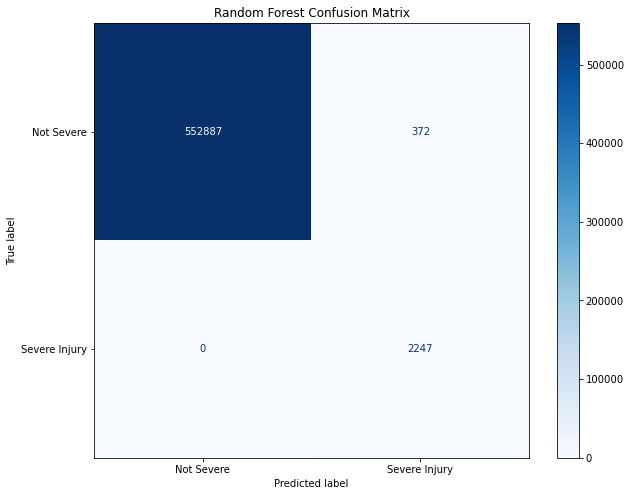

In [20]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(barf, X_test, y_test, display_labels=[
                      "Not Severe", "Severe Injury"], cmap='Blues', values_format='d', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

## Injury Type Prediction

In [21]:
y = ml_merged.InjuryType

# Because the True case only represents 1% of the data, the training split is stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=seed, stratify=y)

In [22]:
# Fit the model
barf.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9862744179064623

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.98      1.00      0.99      0.99      0.98    549957
        7.0       0.81      1.00      1.00      0.89      1.00      1.00       431
       42.0       0.36      0.99      0.99      0.52      0.99      0.98      2484
       48.0       0.28      0.98      0.99      0.44      0.98      0.97      2634

avg / total       0.99      0.98      1.00      0.99      0.99      0.98    555506



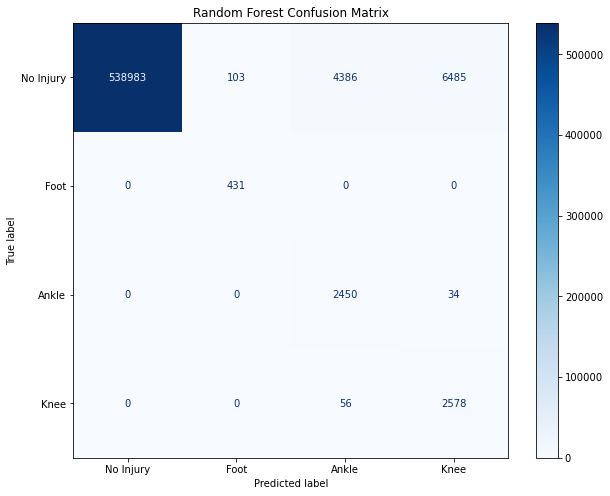

In [24]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(barf, X_test, y_test, display_labels=[
                      "No Injury", "Foot", "Ankle", "Knee"], cmap='Blues', values_format='d', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

## Injury Duration Predictor

In [25]:
y = ml_merged.InjuryDuration

# Because the True case only represents 1% of the data, the training split is stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=seed, stratify=y)

# Fit the model
barf.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = barf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.9977889180426833

In [26]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.99      1.00      0.99      0.99      0.99    549957
        1.0       0.49      1.00      1.00      0.65      1.00      1.00      1209
        7.0       0.48      1.00      1.00      0.65      1.00      1.00      2092
       28.0       0.38      1.00      1.00      0.55      1.00      1.00       472
       42.0       0.51      1.00      1.00      0.67      1.00      1.00      1776

avg / total       0.99      0.99      1.00      0.99      0.99      0.99    555506



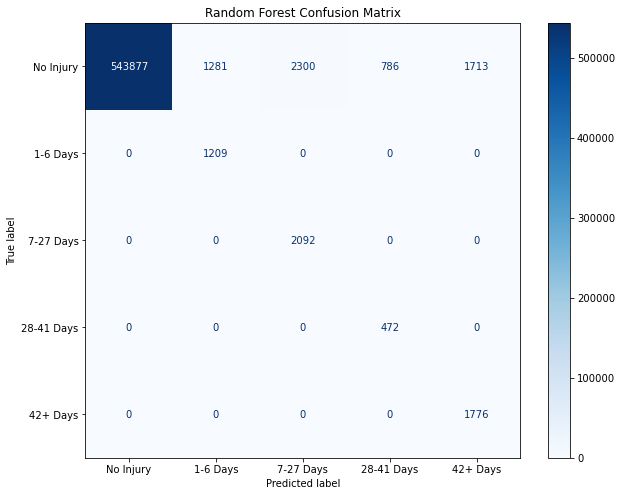

In [27]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(barf, X_test, y_test, display_labels=[
                      "No Injury", "1-6 Days", "7-27 Days", "28-41 Days", "42+ Days"], cmap='Blues', values_format='d', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()


Overall, there is a very low rate of false negatives, which is great! All of the injuries were appropriately identified. There are a higher number of false positives, though these may be considered high-risk plays that just didn't happen to result in an injury. 

---

# Deep Learning with Neural Networks

In [28]:
ml_type = ml_merged.copy(deep=True)
ml_type.drop(columns=['PlayKey', 'IsInjured', 'SevereInjury', 'Position', 'InjuryDuration'], inplace=True)


# Add the Injury Type back to the df
injury = {48.0: 'Knee', 42.0: 'Ankle', 7.0: 'Foot', 0.0: 'NoInjury'}
ml_type['BodyPart'] = ml_type.InjuryType.map(injury)
ml_type.drop(columns='InjuryType', inplace=True)

# Grab all categorical variables and create a list for encoding
cat = ml_type.dtypes[ml_type.dtypes=='object'].index.tolist()

In [29]:
ml_type.head()

,x,y,dir,o,s,RosterPosition,Temperature,PlayerGamePlay,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,BodyPart
0,21.32,29.14,344.76,321.52,0.88,0,63,45,1,1,0,64,0.0,NoInjury
1,21.31,29.21,343.64,328.05,0.91,0,63,45,1,1,0,64,0.0,NoInjury
2,21.30,29.29,342.20,334.59,0.93,0,63,45,1,1,0,64,0.0,NoInjury
3,21.28,29.38,341.12,340.70,0.93,0,63,45,1,1,0,64,0.0,NoInjury
4,21.26,29.45,340.04,346.24,0.89,0,63,45,1,1,0,64,0.0,NoInjury


For the Neural Network Analysis, we will need to have each outcome as a binary classification, thus encoding the Injury types differently with OneHotEncoder

In [30]:
# Create the instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OHE to the columns necessary
encode_df = pd.DataFrame(enc.fit_transform(ml_type[cat]))

# Add the original variable names to the df
encode_df.columns = enc.get_feature_names_out(cat)
encode_df.head()


,BodyPart_Ankle,BodyPart_Foot,BodyPart_Knee,BodyPart_NoInjury
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


In [31]:
# Merge the OHE features and drop the variables
ml_encoded = ml_type.merge(encode_df, left_index=True, right_index=True)
ml_encoded.drop(columns=cat, inplace=True)

In [32]:
ml_encoded.head()

,x,y,dir,o,s,RosterPosition,Temperature,PlayerGamePlay,SyntheticField,Outdoor,Precipitation,DaysPlayed,PlayCode,BodyPart_Ankle,BodyPart_Foot,BodyPart_Knee,BodyPart_NoInjury
0,21.32,29.14,344.76,321.52,0.88,0,63,45,1,1,0,64,0.0,0.0,0.0,0.0,1.0
1,21.31,29.21,343.64,328.05,0.91,0,63,45,1,1,0,64,0.0,0.0,0.0,0.0,1.0
2,21.30,29.29,342.20,334.59,0.93,0,63,45,1,1,0,64,0.0,0.0,0.0,0.0,1.0
3,21.28,29.38,341.12,340.70,0.93,0,63,45,1,1,0,64,0.0,0.0,0.0,0.0,1.0
4,21.26,29.45,340.04,346.24,0.89,0,63,45,1,1,0,64,0.0,0.0,0.0,0.0,1.0


In [33]:
# Prepare the InjuryType Prediction Dataset
y = ml_encoded.loc[:, 'BodyPart_Ankle':]
X = ml_encoded.drop(columns=['BodyPart_Ankle','BodyPart_Foot', 'BodyPart_Knee'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
X_train_scaled = X_scaled.transform(X_train)
X_test_scaled = X_scaled.transform(X_test)

In [48]:
number_input_features = len(X_train_scaled[0])
hidden_layer1 = 16
hidden_layer2 = 8

nn = tf.keras.models.Sequential()

# Layers
nn.add(tf.keras.layers.Dense(units=hidden_layer1, input_dim=number_input_features, activation='relu'))
nn.add(tf.keras.layers.Dense(units=hidden_layer2, activation='relu'))
nn.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))

nn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                240       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
Total params: 412
Trainable params: 412
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [50]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=2)


Epoch 1/2
52079/52079 [==============================] - 36s 688us/step - loss: 0.0043 - accuracy: 0.9971
Epoch 2/2
52079/52079 [==============================] - 37s 716us/step - loss: 6.9482e-04 - accuracy: 0.9995


In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


17360/17360 - 9s - loss: 6.1378e-04 - accuracy: 0.9996 - 9s/epoch - 520us/step
Loss: 0.0006137804593890905, Accuracy: 0.9995913505554199
